In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pickle
from multiprocessing import Pool
import random

In [17]:
## Quantizer NN
class NNQuantizer():
    def __init__(self, iters, dimC):
        self.iters = iters
        self.C = None
        self.A = None
        self.dimC = dimC # How many gradients to keep track of
        
    # What is this function doing
    def load(self, grads):
        self.grads = grads
        self.m = np.shape(grads)[0]
        self.d = (np.shape(grads)[1], np.shape(grads)[2])
        self.betas = np.ones((self.m,)); # Decay vector


    def dot(self, C, A):
        return np.tensordot(A, C, axes=([0],[0]))


    def objective(self, C, A):
        #print(np.shape(C), np.shape(A), np.shape(self.grads))
        total = 0;
        for i in range(self.m):
            # Divinding by norm of gradients for numerical stability
            total += 0.5 * np.square(np.linalg.norm(self.dot(C, A) - self.grads[i])) / np.square(np.linalg.norm(self.grads[i]))
        return total / self.m


    def find(self, u, sv):
        condition = u > ( (sv-1) / range(1,len(u)+1) )
        for i in reversed(range(len(condition))):
            if condition[i]:
                return i


    def projToSmplx(self, v):
        u = np.sort(v)[::-1]
        sv = np.cumsum(u)
        ind = self.find(u,sv)
        theta = (sv[ind]-1) / (ind+1)
        x = np.maximum(v - theta, 0)
        return x
    

    def grad_C(self, C, A):
        g = np.zeros(np.shape(C))
        for i in range(self.m):
            inside = self.dot(C, A) - self.grads[i]
            inside = inside[np.newaxis, :, :]
            add = A[:, np.newaxis, np.newaxis] * np.repeat(inside, C.shape[0], axis = 0)
            # add = np.expand_dims((C@A - self.grads[:,i]),1)@np.expand_dims(A, 1).T
            # add = self.betas[i] * np.outer(C@A - self.grads[:,i], A)
            g += add
        return g


    def grad_A(self, C, A, index):
        g = np.zeros(np.shape(A));
        for i in range(self.m):
            add = np.tensordot(C, self.dot(C, A) - self.grads[i], axes = 2)
            # add = np.tensor(self.dot(C, A) - self.grads[i]);
            g += add
        return g
    

    def compute(self, verbose):
        C = np.random.randn(self.dimC, self.d[0], self.d[1]) if self.C is None else self.C # dimC gradients of size (d[0], d[1])
        A = np.ones((self.dimC)) * 1 / self.dimC if self.A is None else self.A # starting off as probability simplex
        history = 0;
        for iter in range(self.iters):
            c_grad = self.grad_C(C, A);
            obj_value = self.objective(C, A);
            akc = (obj_value + (10/(10+iter)))/np.square(np.linalg.norm(c_grad));
            C = C - akc*c_grad
            a_grad = self.grad_A(C, A, 0);
            aka = (obj_value + (10/(10+iter)))/np.square(np.linalg.norm(a_grad));
            update = A - aka*a_grad
            A = self.projToSmplx(A - aka*a_grad);
        history = obj_value;
        self.C = C
        self.A = A;
        if(verbose):
            plt.plot(range(self.iters), history);
        return history;

    
    def quantize(self, dimC, g):
        dimC = min(dimC, self.dimC)
        #if(dimC == self.dimC):
        #  val = 0;
        #  index = np.random.choice(np.arange(self.dimC), p = self.A);
        #a = cp.Variable(dimC)
        #sum = self.C[0, :, :]*a[0];
        #for i in range(1, dimC):
        #  sum += self.C[i, :, :]*a[i]
        #objective = cp.Minimize(cp.square(cp.norm(sum - g)));
        #constraints = [a >= 0, cp.sum(a) == 1];
        #prob = cp.Problem(objective, constraints);
        #try:
        #  opt = prob.solve("SCS", max_iters=10);
        #  if(opt == float('inf') or prob.status in ['infeasible', 'unbounded']):
        #    index = np.random.choice(np.arange(self.dimC));
        #    return (index, val)
        #  else:
        #    a = a.value/np.sum(a.value);
        #    val = opt
        #    index = np.random.choice(np.arange(self.dimC), p=a);
        #    return (index, val)
        #except:
        index = np.random.choice(np.arange(self.dimC), p=self.A);
        val = np.square(np.linalg.norm(self.C[index, :, :]-g))
        return (index, val)



In [197]:
# Sample Neural Network with 2 Layers -> FC (256 x 1024) - ReLU - FC (1024 x 10)
class AgentNN():
    def __init__(self, x, y, nagents, r, dimC, sigmoid = False, qflag=0):
        self.x = x
        self.y = y
        self.nagents = nagents
        self.r = r
        self.grads1 = []
        self.grads2 = []
        self.PASS = True
        iters = 100
        self.Q1 = NNQuantizer(iters, dimC) # Create a new Quantizer for matrices - first layer
        self.Q2 = NNQuantizer(iters, dimC) # Create a new Quantizer for matrices - second layer
        self.sigmoid = sigmoid
        self.qflag = qflag;

    def sigmoid_func(self, x):
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

    def get_h(self, W1):
        if self.sigmoid:
            return self.sigmoid_func(self.x @ W1)
        return np.maximum(0, self.x @ W1)

    def grad(self, W1, W2, flag):
        # Computer dW2 and dW1
        h = self.get_h(W1)
        dW2 = h.T @ (h @ W2 - self.y)
        self.grads2.append(dW2)

        dh = (h @ W2 - self.y) @ W2.T
        dW1 = self.x.T @ (dh * (h > 0)) # Check this, I think this is right
        if self.sigmoid:
            # dW1 = self.x.T @ (h.T @ (1 - h)) @ dh
            dW1 = self.x.T @ (dh * h * (1 - h))
        self.grads1.append(dW1)

        ch1 = -1
        ch2 = -1
        qh1 = -1
        qh2 = -1
        bits = 0
        if(self.qflag != 0):
          flag = False;

        if (((len(self.grads1) % self.r == 0 and len(self.grads1) != 0) or (len(self.grads1) >= 2 and self.PASS)) and flag):
            G1 = np.zeros((len(self.grads1), self.grads1[0].shape[0], self.grads1[0].shape[1]))
            G2 = np.zeros((len(self.grads2), self.grads2[0].shape[0], self.grads2[0].shape[1]))
            for k in range(len(self.grads1)):
                G1[k, :, :] = self.grads1[k]
                G2[k, :, :] = self.grads2[k]

            self.Q1.load(G1)
            self.Q2.load(G2)

            ch1 = self.Q1.compute(False)
            ch2 = self.Q2.compute(False) # Is there a way to combine ch1 and ch2
            bits += self.Q1.dimC * self.grads1[0].shape[0] * self.grads1[0].shape[1]
            bits += self.Q2.dimC * self.grads2[0].shape[0] * self.grads2[0].shape[1]
            self.grads1 = []
            self.grads2 = []

            self.PASS = False
            print("Recomputing C for layer 1... | Converged with value = ", ch1)
            print("Recomputing C for layer 2... | Converged with value = ", ch2)
        if self.Q1.C is not None and self.Q2.C is not None and flag:
            bits += self.Q1.dimC + self.Q2.dimC # dimC is the same for both Q1 and Q2

            # This needs to be changed to fit the matrix gradient definition
            g1, qh1 = self.Q1.quantize(self.Q1.C.shape[0], dW1)
            g2, qh2 = self.Q2.quantize(self.Q2.C.shape[0], dW2)

            return (self.Q1.C[g1], self.Q2.C[g2], ch1, ch2, qh1, qh2, bits) # return bits here
        else:
            bits += dW1.shape[0]*dW1.shape[1] + dW2.shape[0]*dW2.shape[1] 
            print("Sending full precision gradient")
            if(self.qflag == 2):
              dW1 = np.sign(dW1)
              dW2 = np.sign(dW2)
            return (dW1, dW2, ch1, ch2, qh1, qh2, bits) # return bits here

    def objective(self, W1, W2):
        h = np.maximum(0, self.x @ W1)
        if self.sigmoid:
            h = self.sigmoid_func(self.x @ W1)
        return np.square(np.linalg.norm(h @ W2 - self.y))


class NN():
    def __init__(self, m, nagents, lr, r, dimC, sigmoid = False, qflag=0):
        w1_in = 2
        w2_in = 8
        w_out = 4
        x = np.random.randn(m, w1_in)
        z = np.random.random((w1_in, w2_in)) # Proxy for W1 - not used
        w = np.random.random((w2_in, w_out)) # Proxy for W2 - not used
        y = np.maximum(0, x @ z) @ w;
        self.sigmoid = sigmoid
        if sigmoid:
            y = self.sigmoid_func(x @ z) @ w

        self.optimal = 0 # Not adding noise for now
        
        self.W1 = np.random.rand(w1_in, w2_in) # Not fixed
        self.W2 = np.random.rand(w2_in, w_out) # Not fixed
        self.h = np.maximum(0, x @ self.W1) # Not fixed - Intermediate output after ReLU
        if sigmoid:
            self.h = self.sigmoid_func(x @ z)

        self.m = m
        self.nagents = nagents # Each layers will have this many agents
        self.lr = lr
        self.r = r

        self.agents = self.distribute(x, y, nagents, r, dimC, sigmoid, qflag)
        self.x = x # Fixed
        self.y = y # Fixed


    # def forward(self, update = True):
    #     h = np.maximum(0, self.x @ self.W1)
    #     pred_y = h @ self.W2
    #     self.h = h if update
    #     return pred_y


    def split(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))
    

    def distribute(self, x, y, nagents, r, dimC, sigmoid, qflag):
        agents = [];
        splits = list(self.split(range(self.m), self.nagents))
        
        for sp in splits:
            agents.append(AgentNN(x[sp, :], y[sp, :], self.nagents, r, dimC, sigmoid, qflag))
        return agents


    def computeGradFromLocal(self, W1, W2, flag):
        temp1 = np.zeros_like(W1)
        norm1 = 0
        temp2 = np.zeros_like(W2)
        norm2 = 0
        total_bits = 0

        for i in range(self.nagents):
            localgrad1, localgrad2, ch1, ch2, qh1, qh2, bits = self.agents[i].grad(W1, W2, flag) # return bits from grad
            temp1 += localgrad1
            temp2 += localgrad2
            norm1 += np.linalg.norm(localgrad1)
            norm2 += np.linalg.norm(localgrad2)
            total_bits += bits

        return (temp1 / norm1 / self.nagents, temp2 / norm2 / self.nagents, ch1, ch2, qh1, qh2, total_bits) # return total_bits


    def sigmoid_func(self, x):
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))


    def step(self, i, flag):
        g1, g2, ch1, ch2, qh1, qh2, total_bits = self.computeGradFromLocal(self.W1, self.W2, flag)
        self.W1 = self.W1 - self.lr / np.sqrt(i + 1) * g1
        self.W2 = self.W2 - self.lr / np.sqrt(i + 1) * g2
        return (ch1, ch2, qh1, qh2, total_bits)


    def objective(self):
        return np.sum([self.agents[i].objective(self.W1, self.W2) for i in range(self.nagents)])

    
    def run(self, iters, verbose):
        history = []
        chistory1 = []
        chistory2 = []
        qhistory1 = []
        qhistory2 = []
        i = 0
        run = True
        bhistory = []
        flaghistory = 0

        while run and i < iters:
            h = np.maximum(0, self.x @ self.W1)
            if self.sigmoid:
                h = self.sigmoid_func(self.x @ self.W1)
            print("Current objective value = ", self.objective()) # Try using provided objective function
            gap = (self.objective() - self.optimal)
            print("Iteration = " + str(i) + " | Relative Optimality gap = " + str(gap))
            print("")

            if np.abs(gap) <= 1e-1:
                run = False
            history.append(gap)

            flag = True
            if (i >= self.r):
                flag = (np.diff(history[-3::], 1, 0) >= 0).all()
                flag = not flag
            flaghistory += (flag)


            ch1, ch2, qh1, qh2, total_bits = self.step(i, flag) # return total_bits
            bhistory.append(total_bits)
            if ch1 != -1:
                chistory1.append(ch1)

            if ch2 != -1:
                chistory2.append(ch2)

            if qh1 != -1:
                qhistory1.append(qh1)

            if qh2 != -1:
                qhistory2.append(qh2)

            i += 1

        if verbose:
            plt.yscale('log')
            plt.plot(range(i), history)

        return (history, chistory1, chistory2, qhistory1, qhistory2, bhistory, flaghistory)

In [209]:
## Execute NN without Quantization ##
def execute(nagents, dimC, r, m=10, n=100, iters=1000, lr=1.0, sigmoid = False, qflag = 0): 
    nnexe = NN(m, nagents, lr, r, dimC, sigmoid, qflag)
    history, chistory1, chistory2, qhistory1, qhistory2, bhistory, flaghistory = nnexe.run(iters, True) # return bhistory
    compression = sum(bhistory) / (nagents * iters * (2*8 + 8*4)) # Need to create variable for weight matrices
    # print(f'Compression ratio: {compression}')
    # print(f'Quantized Iterations Ratio: {flaghistory}')
    # # compression ratio = sum(bithistory)/(nagents*32*8*num_iters)
    # print("Optimal = ", nnexe.optimal)
    # print("")
    # print("Done...")
    # print("___________________________________________________________________")
    return history, chistory1, chistory2, qhistory1, qhistory2, compression, flaghistory / iters
    

In [221]:
iters = 1000
nagents = 5
m = 10000
lr = 0.95
sigmoid = False

#exp00 = execute(nagents=nagents, dimC=5, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=2)
#exp0 = execute(nagents=nagents, dimC=5, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=1)

sigmoid = True

#exp00s = execute(nagents=nagents, dimC=5, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=2)
#exp0s = execute(nagents=nagents, dimC=5, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=1)

In [222]:
iters = 1000
nagents = 5
m = 10000
lr = 0.95
sigmoid = False;

#exp1 = execute(nagents=nagents, dimC=5, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=0)
#exp2 = execute(nagents=nagents, dimC=10, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=0)
#exp3 = execute(nagents=nagents, dimC=20, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid, qflag=0)
#exp4 = execute(nagents=nagents, dimC=10, r=10, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp5 = execute(nagents=nagents, dimC=10, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp6 = execute(nagents=nagents, dimC=10, r=100, m=m, iters=iters, lr=lr, sigmoid=sigmoid)


#sigmoid = True # CHANGE TO SIGMOID

#exp7 = execute(nagents=nagents, dimC=5, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp8 = execute(nagents=nagents, dimC=10, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp9 = execute(nagents=nagents, dimC=20, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp10 = execute(nagents=nagents, dimC=10, r=10, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp11 = execute(nagents=nagents, dimC=10, r=50, m=m, iters=iters, lr=lr, sigmoid=sigmoid)
#exp12 = execute(nagents=nagents, dimC=10, r=100, m=m, iters=iters, lr=lr, sigmoid=sigmoid)

Compression1: 0.47308333333333336
Quantize1: 0.755
Compression2: 0.6579166666666667
Quantize2: 0.776
Compression3: 1.2046666666666668
Quantize3: 0.813


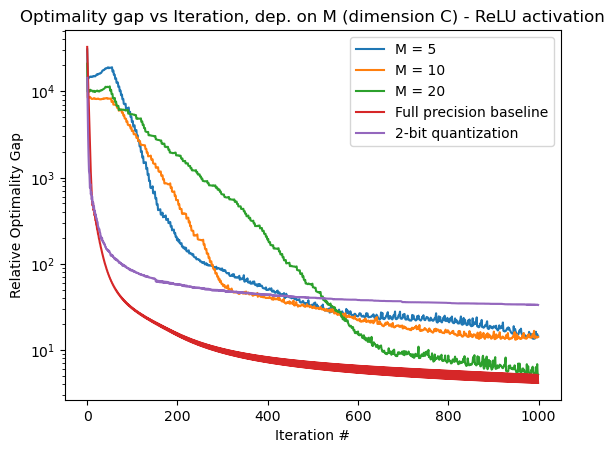

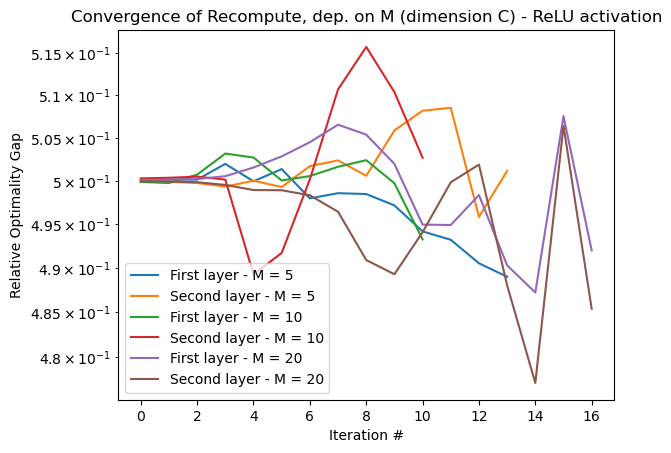

Compression1: 1.2808333333333333
Quantize1: 0.771
Compression2: 0.7255833333333334
Quantize2: 0.78
Compression3: 0.60275
Quantize3: 0.802


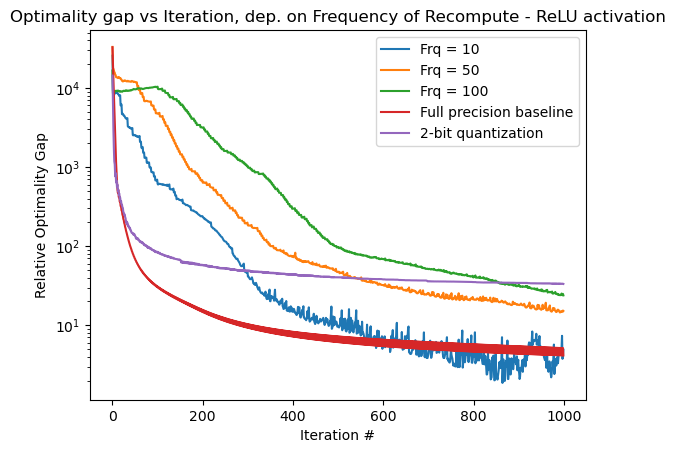

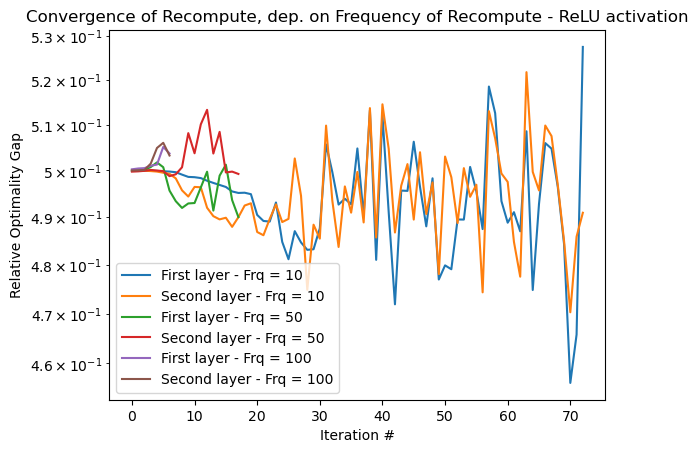

Compression1: 0.4765
Quantize1: 0.757
Compression2: 0.6430833333333333
Quantize2: 0.87
Compression3: 1.1221666666666668
Quantize3: 0.828


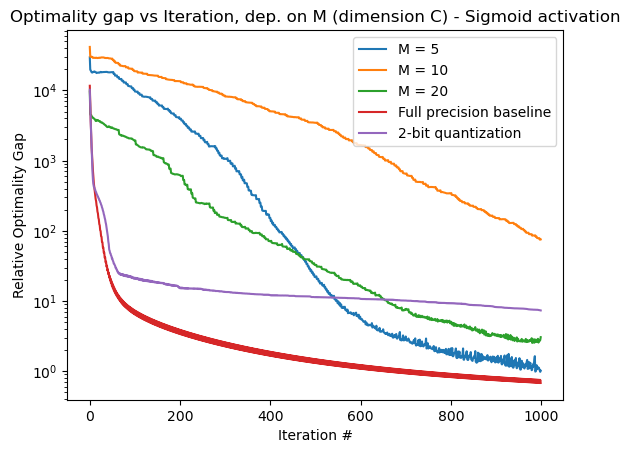

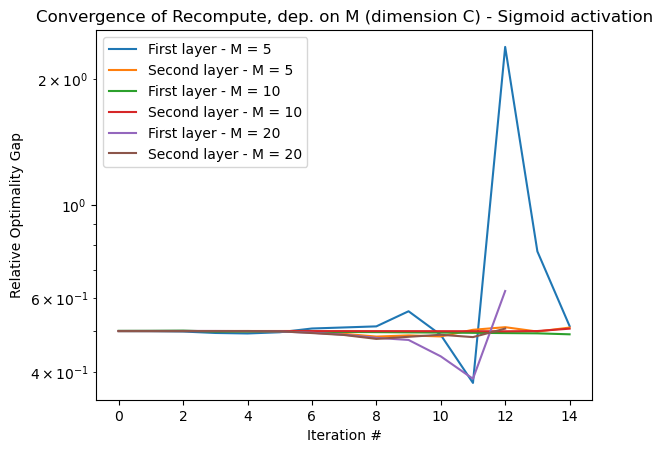

Compression1: 1.3566666666666667
Quantize1: 0.761
Compression2: 0.6834166666666667
Quantize2: 0.818
Compression3: 0.61675
Quantize3: 0.778


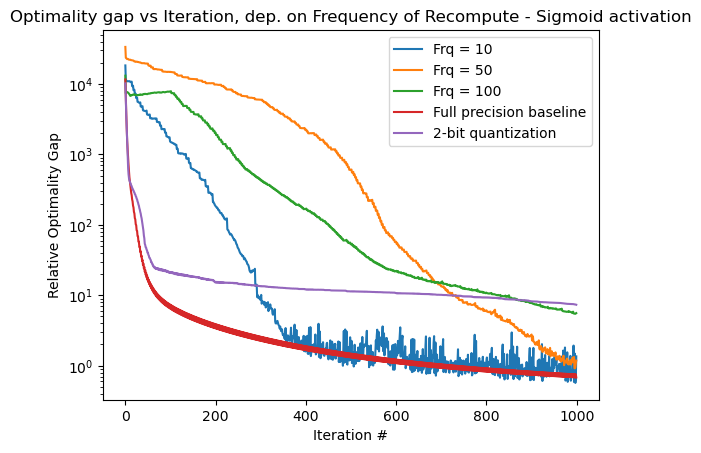

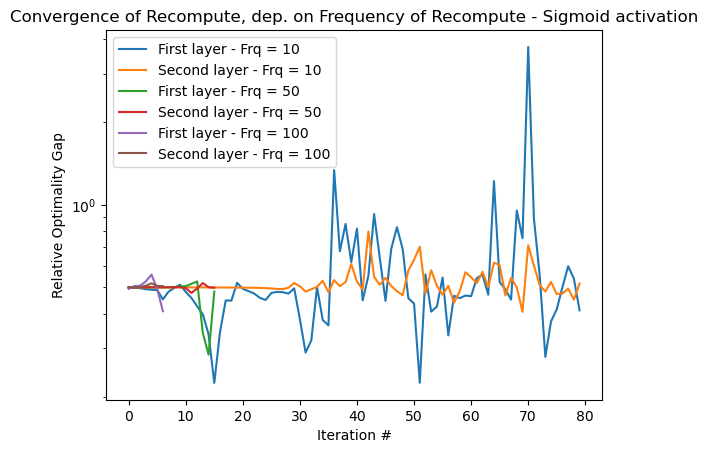

In [224]:
# BATCH 1
print(f'Compression1: {exp1[5]}')
print(f'Quantize1: {exp1[6]}')
print(f'Compression2: {exp2[5]}')
print(f'Quantize2: {exp2[6]}')
print(f'Compression3: {exp3[5]}')
print(f'Quantize3: {exp3[6]}')

# History plot - varying dimC, relu
plt.figure(1)
plt.plot(range(iters), exp1[0], label = 'M = 5')
plt.plot(range(iters), exp2[0], label = 'M = 10')
plt.plot(range(iters), exp3[0], label = 'M = 20')
plt.plot(range(iters), exp0[0], label = 'Full precision baseline')
plt.plot(range(iters), exp00[0], label = '2-bit quantization')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on M (dimension C) - ReLU activation")
plt.legend()
plt.show()

# Compute history - varying dimC, relu
plt.figure(1)
plt.plot(range(len(exp1[1])), exp1[1], label = 'First layer - M = 5')
plt.plot(range(len(exp1[2])), exp1[2], label = 'Second layer - M = 5')
plt.plot(range(len(exp2[1])), exp2[1], label = 'First layer - M = 10')
plt.plot(range(len(exp2[2])), exp2[2], label = 'Second layer - M = 10')
plt.plot(range(len(exp3[1])), exp3[1], label = 'First layer - M = 20')
plt.plot(range(len(exp3[2])), exp3[2], label = 'Second layer - M = 20')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Convergence of Recompute, dep. on M (dimension C) - ReLU activation")
plt.legend()
plt.show()



# BATCH 2
print(f'Compression1: {exp4[5]}')
print(f'Quantize1: {exp4[6]}')
print(f'Compression2: {exp5[5]}')
print(f'Quantize2: {exp5[6]}')
print(f'Compression3: {exp6[5]}')
print(f'Quantize3: {exp6[6]}')

# History plot - varying r, relu
plt.figure(1)
plt.plot(range(iters), exp4[0], label = 'Frq = 10')
plt.plot(range(iters), exp5[0], label = 'Frq = 50')
plt.plot(range(iters), exp6[0], label = 'Frq = 100')
plt.yscale("log")
plt.plot(range(iters), exp0[0], label = 'Full precision baseline')
plt.plot(range(iters), exp00[0], label = '2-bit quantization')
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on Frequency of Recompute - ReLU activation")
plt.legend()
plt.show()

# Compute history - varying r, relu
plt.figure(1)
plt.plot(range(len(exp4[1])), exp4[1], label = 'First layer - Frq = 10')
plt.plot(range(len(exp4[2])), exp4[2], label = 'Second layer - Frq = 10')
plt.plot(range(len(exp5[1])), exp5[1], label = 'First layer - Frq = 50')
plt.plot(range(len(exp5[2])), exp5[2], label = 'Second layer - Frq = 50')
plt.plot(range(len(exp6[1])), exp6[1], label = 'First layer - Frq = 100')
plt.plot(range(len(exp6[2])), exp6[2], label = 'Second layer - Frq = 100')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Convergence of Recompute, dep. on Frequency of Recompute - ReLU activation")
plt.legend()
plt.show()




# BATCH 3
print(f'Compression1: {exp7[5]}')
print(f'Quantize1: {exp7[6]}')
print(f'Compression2: {exp8[5]}')
print(f'Quantize2: {exp8[6]}')
print(f'Compression3: {exp9[5]}')
print(f'Quantize3: {exp9[6]}')

# History plot - varying dimC, sigmoid
plt.figure(1)
plt.plot(range(iters), exp7[0], label = 'M = 5')
plt.plot(range(iters), exp8[0], label = 'M = 10')
plt.plot(range(iters), exp9[0], label = 'M = 20')
plt.plot(range(iters), exp0s[0], label = 'Full precision baseline')
plt.plot(range(iters), exp00s[0], label = '2-bit quantization')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on M (dimension C) - Sigmoid activation")
plt.legend()
plt.show()

# Compute history - varying dimC, sigmoid
plt.figure(1)
plt.plot(range(len(exp7[1])), exp7[1], label = 'First layer - M = 5')
plt.plot(range(len(exp7[2])), exp7[2], label = 'Second layer - M = 5')
plt.plot(range(len(exp8[1])), exp8[1], label = 'First layer - M = 10')
plt.plot(range(len(exp8[2])), exp8[2], label = 'Second layer - M = 10')
plt.plot(range(len(exp9[1])), exp9[1], label = 'First layer - M = 20')
plt.plot(range(len(exp9[2])), exp9[2], label = 'Second layer - M = 20')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Convergence of Recompute, dep. on M (dimension C) - Sigmoid activation")
plt.legend()
plt.show()



# BATCH 4
print(f'Compression1: {exp10[5]}')
print(f'Quantize1: {exp10[6]}')
print(f'Compression2: {exp11[5]}')
print(f'Quantize2: {exp11[6]}')
print(f'Compression3: {exp12[5]}')
print(f'Quantize3: {exp12[6]}')

# History plot - varying r, sigmoid
plt.figure(1)
plt.plot(range(iters), exp10[0], label = 'Frq = 10')
plt.plot(range(iters), exp11[0], label = 'Frq = 50')
plt.plot(range(iters), exp12[0], label = 'Frq = 100')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on Frequency of Recompute - Sigmoid activation")
plt.plot(range(iters), exp0s[0], label = 'Full precision baseline')
plt.plot(range(iters), exp00s[0], label = '2-bit quantization')
plt.legend()
plt.show()

# Compute history - varying r, sigmoid
plt.figure(1)
plt.plot(range(len(exp10[1])), exp10[1], label = 'First layer - Frq = 10')
plt.plot(range(len(exp10[2])), exp10[2], label = 'Second layer - Frq = 10')
plt.plot(range(len(exp11[1])), exp11[1], label = 'First layer - Frq = 50')
plt.plot(range(len(exp11[2])), exp11[2], label = 'Second layer - Frq = 50')
plt.plot(range(len(exp12[1])), exp12[1], label = 'First layer - Frq = 100')
plt.plot(range(len(exp12[2])), exp12[2], label = 'Second layer - Frq = 100')
plt.yscale("log")
plt.xlabel("Iteration #")
plt.ylabel("Relative Optimality Gap")
plt.title("Convergence of Recompute, dep. on Frequency of Recompute - Sigmoid activation")
plt.legend()
plt.show()